In [69]:
import numpy as np
import pygimli as pg
import pygimli.meshtools as mt
from pygimli.physics import ert

In [70]:
eldist = 0.023
eldia = 0.0075
size2 = 0.05
plc = mt.createWorld(start=[-size2, -size2, -size2], end=[size2+3*eldist, size2, 0], area=2e-7)
for i in range(4):
    pad = mt.createFacet(mt.createCircle(pos=[i*eldist, 0, 0], radius=eldia/2, nSegments=16, isHole=True)) 
    plc.copyBoundary(pad.boundary(0))
    plc.createBoundary(plc.nodes([plc.createNode(n.pos()).id() for n in pad.nodes() ]), marker=-10000-i) # -10000-1)

for x in np.arange(0, 3*eldist, 0.0001):
    plc.createNode([x, 0, -0.0001])

mesh = mt.createMesh(plc, quality=1.15)
print(mesh)
mesh.node(0).setMarker(-999)
mesh.node(1).setMarker(-1000)
print(np.unique(mesh.boundaryMarkers()))
pg.show(mesh, showMesh=True, markers=True, backend="trame")

Mesh: Nodes: 12286 Cells: 58858 Boundaries: 122768
[-10003 -10002 -10001 -10000     -2     -1      0]


25/10/23 - 19:42:30 - pyGIMLi - WARNING - Given data fits neither cell count nor node count:
25/10/23 - 19:42:30 - pyGIMLi - WARNING - 122768 vs. 0 vs. 5054


Widget(value="<iframe src='http://localhost:51158/index.html?ui=P_0x2514ad5b5b0_5&reconnect=auto' style='width…

(<pyvista.plotting.plotting.Plotter at 0x2514ad5b5b0>, None)

In [71]:
shm = pg.DataContainerERT()
for i in range(4):
    shm.createSensor([i*eldist, 0, 0])

shm.addFourPointData(0, 3, 1, 2)
print(shm)
shm["k"] = 1.  # set to 1 so that it can be computed

Data: Sensors: 4 data: 1, nonzero entries: ['a', 'b', 'm', 'n', 'valid']


The geometric factor is the ratio of the resistivity and the computed resistance.

In [72]:
shm["k"] = 1. / ert.simulate(mesh, shm, res=1.0, sr=False, verbose=True, returnArray=True)

In [76]:
fop = ert.ERTModelling(sr=False, verbose=True)
fop.setData(shm)
fop.setMesh(mesh)
fop._core.setContactImpedances(np.ones(shm.sensorCount())*1e-12)
fop._core.createRefinedForwardMesh(True, False)
model = np.ones(mesh.cellCount()) * 100
res = fop.response(model)
print(res)  # should be 100
fop.createJacobian(model)
sens = fop.jacobian()[0]

25/10/23 - 19:43:54 - pyGIMLi - INFO - Found 1 regions.
25/10/23 - 19:44:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
25/10/23 - 19:44:10 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
25/10/23 - 19:44:19 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 88481 Cells: 470864 Boundaries: 491072
Mesh contains data: normsens, sens


1 [99.7692843916539]


In [77]:
mesh["sens"] = sens / mesh.cellSizes()
mesh["normsens"] = pg.utils.logDropTol(sens/mesh.cellSizes(), 1e1)
sli = mt.extract2dSlice(mesh)

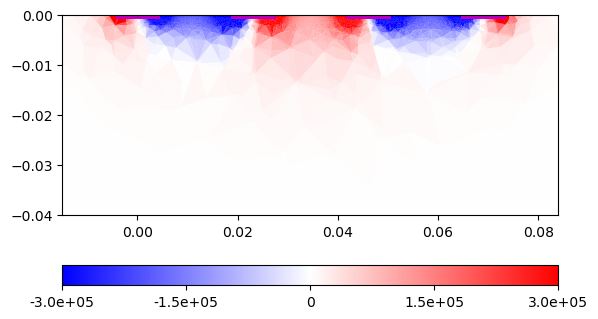

In [78]:
mm = 3e5
ax, cb = pg.show(sli, "sens", cMin=-mm, cMax=mm, cMap="bwr")
ax.set_xlim(-0.015, 3*eldist+0.015)
ax.set_ylim(-0.04, 0)
for i in range(4):
    ax.plot([i*eldist-eldia/2, i*eldist+eldia/2], [0, 0], "m-", lw=5)